#  Classificação Automatizada de Intenções em Textos em Linguagem Natural 

Este workshop apresenta técnicas e modelos para classificar mensagens **quanto a níveis de agressividade**. O reconhecimento de Intenções desenvolve um papel chave na interpretação de sentenças em língua natural. Exploraremos principalmente o modelo de linguagem BERT e seu refinamento para o processamento de sentenças na **língua inglesa**. Apresentamos técnicas e métodos para se aplicar classificadores com base nesse modelo para o reconhecimento de múltiplos níveis de intenções nos textos. O Workshop usará como aplicação prática a classificação de comentários do Twitter.

# O que é NLP?

**NLP** significa _Natural Language Processing_, são diversas técnicas e modelos computacionais usados para criar programas e sistemas computacionais capazes de interpretar e entender a linguágem humana.

Normalmente, quando trabalhamos com NLP, precisamos seguir os seguintes passos:
- Pegar os dados textuais (normalmente não estruturados, apenas texto)
- Limpa-los (para remover errors gramaticais, pontuação etc...)
- Tokeniza-los (transforma-los em números)
- Aplicar os dados no algoritmo
- Interpretar a saída

**Exemplos de algoritmos/usos de Processamento de Linguagem Natural:**
- O Autocorretor do seu celular
- Filtros de email
- Tradutores
- Barra de Pesquisa do Google
- Etc...

Como dito anteriormente, estaramos trabalhando com um **classificador de intenções**.

# O que é um Classificador?

Classificadores são algoritmos capazes de receber uma entrada X e classifica-la em grupos (também chamado de _labels_) diferentes.

Classificadores são algoritmos/modelos que normalmente usam Aprendizado Supervisionado, isso é, inicialmente, você irá treina-lo com os dados x e as saídas corretas y. O modelo de IA irá tentar adapar sua matemática interna (utilizando métodos estatísticos para reduzir o erro) até ficar o mais próximo possível dos valores reais. Ai finalmente ele estará pronto para ser usado com dados reais, que não possuem sua saída correta y criada ainda.

# O que é uma Intenção?

_Intenção_ é a palavra que usamos para referir ao objetivo de um texto ou mensagem, e as intenções variam com o contexto. Quando dizemos que algo é _multilabel_, queremos dizer que é possível ter várias intenções na mesma fala. Veja esse exemplo de uma conversa entre um cliente e um atendente:

- Olá, tudo bem? - [Cumprimento]
- Olá. Você sabe o seu CPF? - [Cumprimento][Pedir CPF]
- Infelizmente não sei. Mas posso dizer meu número. - [Negativa][Informar Numero]
- Opa, isso funciona. Qual é? - [Confirmação][Pedir Número]
- O número é 9123-4567 - [Informar Número]



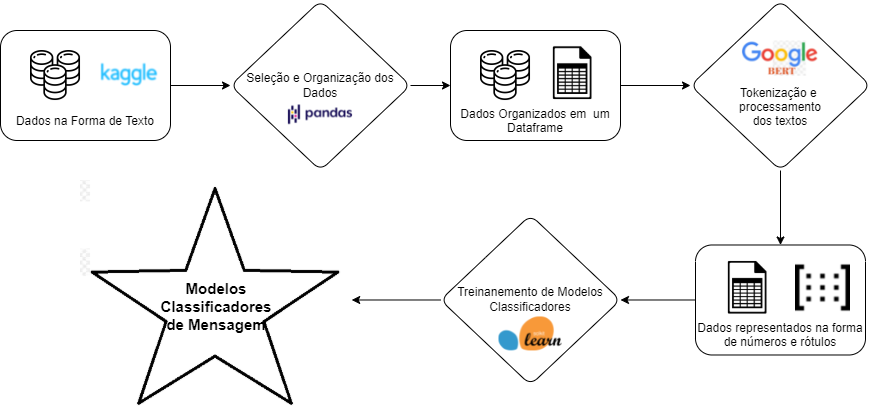

# Importando as Bibliotecas

Nesse hands-on, trabalharemos com algumas bibliotecas conhecidas do python (pandas, numpy, etc...) e a biblioteca Transformers, que possui o modelo BERT de Inteligência Artificial, que explicaremos um pouco mais para a frente.

Vamos começar importando:

In [ ]:
#importar bibliotecas importantes
import pandas as pd
import numpy as np

#BERT:
!pip install Transformers
import torch


# Carregando os Dados

Os dados que trabalharemos serão dados reais tirados de comentários da internet, muitos deles são comentários tóxicos e agressivos. O nosso objetivo é criar uma inteligência artificial capaz de reconhecer esses comentários agressivos e classifica-los no seu tipo de toxidade (se é um insulto, ameaça, etc...).

Esse tipo de IA é muito utilizado em mídias sociais.

Vamos começar fazendo o download dos dados que salvamos no google drive e olhando como eles se parecem:


In [ ]:
#carregar dados
!gdown --id 1Vl-71bATv5TRuqgtqqiRegVHBAsdAJ32

Downloading...
From: https://drive.google.com/uc?id=1Vl-71bATv5TRuqgtqqiRegVHBAsdAJ32
To: /content/toxic_comments.csv
100% 55.6M/55.6M [00:00<00:00, 255MB/s]


In [ ]:
dataset = pd.read_csv('/content/toxic_comments.csv')

In [ ]:
dataset

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
155737,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
155738,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
155739,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
155740,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [ ]:
dataset.query('insult==1').describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,7684.000000,7684.000000,7684.000000,7684.000000,7684.0,7684.000000
mean,0.931806,0.165539,0.779542,0.038652,1.0,0.146278
std,0.252094,0.371690,0.414583,0.192776,0.0,0.353408
min,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,1.000000,0.000000,1.000000,0.000000,1.0,0.000000
50%,1.000000,0.000000,1.000000,0.000000,1.0,0.000000
75%,1.000000,0.000000,1.000000,0.000000,1.0,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


# Sobre os nossos dados

Como pode ver, temos 155.742 comentários de diferentes toxidades. O texto do comentário está inteiramente em *comment_text* (que possui dados sujos, como o caractere *\n* que significa 'pular linha'). O comment_text será os nossos dados *x* (de entrada), enquanto todas as classificações possíveis serão os nossos dados *y* (dados de saída) que serão utilizados para treinar o dataset.

In [ ]:
dataset = dataset.drop(columns=['id'])

In [ ]:
#salvar as labels em uma lista
labels = dataset.columns.to_list()
labels.pop(0)
labels


['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Processamento dos Dados

Como falamos antes, agora que já temos os nossos dados, está na hora de limpa-los. O BERT já é imbutido com funções de limpeza e tokenização, que iremos usar.

Para você entender o que está acontecendo abaixo, precisamos explicar dois conceitos:

- **Modelos Pré-Treinados:** Como dito antes, modelos de inteligência artificial precisam ser _treinados_ com dados. As vezes, já existem algums modelos pré-prontos com algumas coisas já treinadas e queremos usa-los para não perder tempo re-treinando. Por isso, usaremos a função .from_pretrained, utilizando um BERT já treinado.

- **Tokenizer**: Tokenizar é a ação de transformar palavras em Tokens. Há diversos pequenos detalhes na implementação de tokens, mas em suma, ele irá transformar palavras em números. Tokenizadores são criados para trabalhar de diversas formas: diferenciando ou não maiusculo e minúsculo (para saber se 'Pessoa' e 'pessoa' sao iguais, pois as vezes queremos separar nomes como 'Fernando Pessoa' da palavra 'pessoa'), ignorando ou não pontuação, etc...

Normalmente, um Tokenizador do BERT faz os seguintes passos:

![Tokenizador](https://miro.medium.com/max/1838/1*f8NBZIutC7PuGo21rsVVkw.png)
Créditos: [Satish1v](https://satish1v.medium.com/tokenization-for-bert-models-5c20734d1aca)



In [ ]:
#instanciar o BERT

from transformers import AutoModel
from transformers import AutoTokenizer

Bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-cased', do_lower_case=False) 
Bert_model = AutoModel.from_pretrained('bert-base-cased')





Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#habilitar GPU

Bert_model.cuda();
torch.cuda.get_device_name(0)

'Tesla T4'

# Com o BERT Funciona

**BERT** é um algoritmo criado pelo Google e lançado em 2018. Ele é considerado ainda o _estado da arte_ das Inteligências Artificiais que trabalham com NLP. BERT significa _Bidirectional Encoder Representations from Transformers_, vamos explicar um pouquinho como ele funciona agora.

Primeiramente, ele funciona _transformando_ (Transformers) as palavras em tokens. Essa é a parte dos Encoders e Transformers: Transformers é um bloco de Encoders que irá transformar as palavras em números de tal forma que os seus valores numéricos estejam relacionados com seu significado em frases.

Após isso, ele lê as frases (transformadas em números) de trás para frente e frente para trás (por isso é bidirecional), fazendo uma combinação matemática com as palavras e criando um vetor que irá representar a frase.

In [ ]:
#funcao que recebe um tweet (string) e retorna seu vetor de embbeding (lista de floats)
def processa_tweet(tweet):
  input_ids = Bert_tokenizer.encode(tweet, return_tensors='pt').cuda()
  with torch.no_grad():
    outs = Bert_model(input_ids)
    vetor_embbeding = outs.last_hidden_state[0][0]
    vetor_embbeding = vetor_embbeding.tolist()
  return vetor_embbeding

def gera_lista_vetores(dataset):
  dataset_processado = pd.DataFrame()
  for index, row in dataset.iterrows():
    row['comment_text'] = row['comment_text'].replace('\n', ' ')
    tweet = row['comment_text']
    row['vetor_embbeding'] = processa_tweet(tweet)
    dataset_processado = dataset_processado.append(row)
  return dataset_processado



In [ ]:
dataset_processado = gera_lista_vetores(dataset[:10000])


In [ ]:
dataset_processado_mostrar = pd.DataFrame()
dataset_processado_mostrar['comment_text'] = dataset_processado['comment_text']
dataset_processado_mostrar['vetor_embbeding'] = dataset_processado['vetor_embbeding']
dataset_processado_mostrar


# Acho que aqui, tirar os y para dar a entender que não classificamos ainda.

,comment_text,vetor_embbeding
0,Explanation Why the edits made under my userna...,"[0.5411035418510437, 0.019211601465940475, 0.1..."
1,D'aww! He matches this background colour I'm s...,"[0.34275734424591064, -0.10840089619159698, 0...."
2,"Hey man, I'm really not trying to edit war. It...","[0.5680204033851624, 0.23963823914527893, -0.1..."
3,""" More I can't make any real suggestions on im...","[0.4536437392234802, 0.2508940100669861, -0.00..."
4,"You, sir, are my hero. Any chance you remember...","[0.5971534252166748, 0.1074175015091896, 0.012..."
...,...,...
9995,Thanks for looking after this user. I am a bit...,"[0.7113430500030518, 0.291189968585968, -0.038..."
9996,Improvement needed While I've declined speed...,"[0.5235295295715332, -0.12085855007171631, 0.0..."
9997,"Hey, faggot. You fucking retard. You better ...","[0.45448148250579834, 0.6303014755249023, 0.20..."
9998,"Sorry, but no. The idea of a partial rather th...","[0.6648085117340088, -0.09976459294557571, 0.2..."


# Treinando o Modelo Classificador

Pronto, agora que o BERT fez sua parte, precisamos saber como interpretar esses vetores para dizer se uma frase é tóxica ou não. Normalmente isso é feito pegando a saída do BERT e aplicando em alguma rede especializada em classificação. Isso nos dá liberdade de pegar os modelos que achamos mais interessantes para um dado problema.

Veja só esse exemplo com um classificador de SPAM:

![BERT Spam](https://i.imgur.com/MFd6n82.png)
Créditos: [dipanjanS](https://imgur.com/MFd6n82)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.base import clone

In [ ]:
#Dividir em Dados de Treino e de Teste
dados_treino, dados_teste = train_test_split(dataset_processado, test_size=0.2, random_state=42)

X_treino = list(dados_treino['vetor_embbeding'])
X_teste = list(dados_teste['vetor_embbeding'])


In [ ]:
#modelo = LogisticRegression(max_iter=1000)
dicionario_modelos = dict()


#Realizar fit de Modelos Classificadores
for label in labels:
  Y_treino = np.asarray(dados_treino[label])
  Y_teste = np.asarray(dados_teste[label])
  dicionario_modelos[label] = LogisticRegression(max_iter=1000)#clone(modelo)
  dicionario_modelos[label].fit(X_treino, Y_treino)
  acuracia = dicionario_modelos[label].score(X_teste, Y_teste)
  print(f'acuracia para {label}:', acuracia)


acuracia para toxic: 0.9355
acuracia para severe_toxic: 0.989
acuracia para obscene: 0.9605
acuracia para threat: 0.9985
acuracia para insult: 0.958
acuracia para identity_hate: 0.9895


# Verificar Classificações de Mensagens

Vamos agora verificar qualitativamente como o modelo classifica mensagens quanto a sua agressividades. Para isso escolhemos alguns exemplos, que são mostrados abaixo. 

No dataset utilizado para treinamento e teste, há algumas mensagens muito agressivas. Optamos por não mostrá-las explicitamente nessa demonstração. No entanto, é importante ressaltar que elas fazem parte do processo de geração destes modelos.

In [ ]:
def classifica_tweets(tweets):
  for tweet in tweets:
    vetor = np.asarray(processa_tweet(tweet))
    vetor = vetor.reshape(1,-1)
    print('mensagem:\n', tweet,'\n\n')
    print('Classificão:')
    for label in labels:
      predicao = dicionario_modelos[label].predict(vetor)
      predicao = predicao[0]
      print(f'predição para {label}:', predicao)
    print('\n', '-'*100)


**Mensagens de Ameaça**

In [ ]:
#ameaça
tweet1_ameaça = 'I am coming to get you. I know where you live and im going to kill you '
tweet2_ameaça = 'I will kill you'
tweet3_ameaça = 'I am going to track you down and do violent things to you'


tweets_ameaca = [tweet1_ameaça, tweet2_ameaça, tweet3_ameaça]



In [ ]:
classifica_tweets(tweets_ameaca)

mensagem:
 I am coming to get you. I know where you live and im going to kill you  


Classificão:
predição para toxic: 1.0
predição para severe_toxic: 0.0
predição para obscene: 0.0
predição para threat: 1.0
predição para insult: 0.0
predição para identity_hate: 0.0

 ----------------------------------------------------------------------------------------------------
mensagem:
 I will kill you 


Classificão:
predição para toxic: 0.0
predição para severe_toxic: 0.0
predição para obscene: 0.0
predição para threat: 1.0
predição para insult: 0.0
predição para identity_hate: 0.0

 ----------------------------------------------------------------------------------------------------
mensagem:
 I am going to track you down and do violent things to you 


Classificão:
predição para toxic: 1.0
predição para severe_toxic: 0.0
predição para obscene: 0.0
predição para threat: 1.0
predição para insult: 0.0
predição para identity_hate: 0.0

 ----------------------------------------------------------

**Mensagens de Insulto**

In [ ]:
#insult
tweet1_insulto = 'You asshole'
tweet2_insulto = 'You are a total loser. Get out of my page'
tweet3_insulto = 'You are a creepy thing. You mule'

tweets_insulto = [tweet1_insulto, tweet2_insulto, tweet3_insulto ]

In [ ]:
classifica_tweets(tweets_insulto)

mensagem:
 You asshole 


Classificão:
predição para toxic: 1.0
predição para severe_toxic: 0.0
predição para obscene: 1.0
predição para threat: 0.0
predição para insult: 1.0
predição para identity_hate: 0.0

 ----------------------------------------------------------------------------------------------------
mensagem:
 You are a total loser. Get out of my page 


Classificão:
predição para toxic: 1.0
predição para severe_toxic: 0.0
predição para obscene: 1.0
predição para threat: 0.0
predição para insult: 1.0
predição para identity_hate: 0.0

 ----------------------------------------------------------------------------------------------------
mensagem:
 You are a creepy thing. You mule 


Classificão:
predição para toxic: 1.0
predição para severe_toxic: 0.0
predição para obscene: 1.0
predição para threat: 0.0
predição para insult: 1.0
predição para identity_hate: 0.0

 ----------------------------------------------------------------------------------------------------
